In [27]:
suppressMessages(library(tmvtnorm))
suppressMessages(library(HLSM))
suppressMessages(library(mvtnorm))
suppressMessages(library(truncnorm))
suppressMessages(library(MCMCpack))

# Hierarchical SVD

DATA: 15 Advice-seeking Networks among instructors (Sweet et. al. (2012))

In [28]:
nk = unlist(lapply(ps.advice.mat, nrow)) #ps.advice.mat is the network data provided by HLSM package
nk # Sizes of networks of 15 schools

[1] 30 21 25 19 26 49 76 42 33 29 12 28 14 14 15

In [30]:
K = 15
iternum = 1000 # number of iterations

# Create a list to collect MCMC samples
Chain = list("beta" = list(), 
             "rho" = matrix(nrow=iternum,ncol=N), 
             "sigma_ab" = list(), "sigma_uv" = list(),
             "U" = list(), "V" = list(), 
             "a" = list(), "b" = list(), 
             "z" = list())

for (i in 1:K){
  Chain$U[[i]] = Chain$V[[i]] = list()
  for (j in 1:iternum){
    Chain$U[[i]][[j]] = Chain$V[[i]][[j]] = list()
  }
  Chain$beta[[i]] = matrix(nrow=iternum,ncol=2)
  Chain$a[[i]] = Chain$b[[i]] = matrix(nrow=iternum, ncol=nk[i])
}

### Covariate Matrix (Edge attribute)
A Matrix with binary values -- if a pair of teachers is teaching the same grade in a school, then 1.

In [32]:
Cov1 = list()
for (i in 1:K){
  Cov1[[i]] = array(ps.edge.vars.mat[[i]][,,3],dim=c(nrow(ps.edge.vars.mat[[i]][,,3]), 
                                                     nrow(ps.edge.vars.mat[[i]][,,3]),
                                                     1))
  Cov1[[i]][1,1,1] = NA
}

In [25]:
Cov1[[11]][,,1] # Covariate Matrix for School 11.

NA,0,0,0,0,0,0,0,0,0,0,0
0,NA,0,0,0,0,0,0,0,0,0,0
0,0,NA,0,0,1,0,0,0,0,1,0
0,0,0,NA,0,0,0,1,0,0,0,0
0,0,0,0,NA,0,0,0,0,0,0,0
0,0,1,0,0,NA,0,0,0,0,1,0
0,0,0,0,0,0,NA,0,0,0,0,0
0,0,0,1,0,0,0,NA,0,0,0,0
0,0,0,0,0,0,0,0,NA,0,0,0
0,0,0,0,0,0,0,0,0,NA,0,0
0,0,1,0,0,1,0,0,0,0,NA,0


### Random Initial Points for MCMC

In [34]:
# Random Initial points for U and V
U = V = list()
for (i in 1:K){
  U[[i]] = as.matrix(rmvnorm(nk[i],c(0,0),diag(0.01,2)),ncol=2)
  V[[i]] = as.matrix(rmvnorm(nk[i],c(0,0),diag(0.01,2)),ncol=2)
}

# Create Starting points for z, a, b
z = list()
a = list()
b = list()

s02 = 1; s2 = 1 # s02, s2 -> sigma for beta0 and beta1

# sigma_ab
sigma_ab = matrix(c(1,0.5,0.5,1),2,2) 

# sigma_uv
sigma_uv =  matrix(0.5,4,4)
diag(sigma_uv) = 1


# fill in z,a,b with random numbers
for (k in 1:K){
  z[[k]] = matrix(rnorm(nk[k]*nk[k]), ncol=nk[k],nrow=nk[k])
  diag(z[[k]]) = NA
  a[[k]] = b[[k]] = numeric(nk[k])
  
  for (i in 1:nk[k]){
    sig_ab = 0.2
    rho_ab = 0.3*sig_ab
    ab0 = rmvnorm(1,c(0,0),matrix(sig_ab*c(1,rho_ab,rho_ab,1),nrow=2))
    a[[k]][i] = ab0[1]
    b[[k]][i] = ab0[2]
  }
}

#initial for rho, beta0, beta1
rho = rep(0.5,K)
beta0 = rnorm(K,0,1)
beta1 = rnorm(K,0,1)
beta = cbind(beta0,beta1)

In [35]:
# function calculating latent score, z
eta = function(beta, x, u, v, a, b){
  beta[1] + beta[2]*x + t(u)%*%v + a + b
}

# function calculating log density ratio for rho and rho_proposal
rho_dens = function(rho, rho_p, z, beta, Cov1, a, b, U, V, nk){
  d = 0
  etilde = matrix(NA,nk,nk)
  for (i in 1:nk){
    for (j in 1:nk){
      if (i < j){
        etilde[i,j] = z[i,j] - beta[1] - Cov1[i,j,1]%*%beta[2] - a[i] - b[j] - U[i,] %*% V[j,]
        etilde[j,i] = z[j,i] - beta[1] - Cov1[j,i,1]%*%beta[2] - a[j] - b[i] - U[j,] %*% V[i,]
        d = d + 
           -1/2*log(1-rho_p^2) - 1/2 * t(c(etilde[i,j], etilde[j,i])) %*% solve(matrix(c(1,rho_p,rho_p,1),2,2)) %*% c(etilde[i,j], etilde[j,i]) - (
           -1/2*log(1-rho^2  ) - 1/2 * t(c(etilde[i,j], etilde[j,i])) %*% solve(matrix(c(1,rho  ,  rho,1),2,2)) %*% c(etilde[i,j], etilde[j,i]) )
        
      }
    }
  }
  return(d)
}

# function product
f = function(x) x%*%t(x)


## MCMC

\begin{align*}
Y_{ijk} &= \bf{1}_{[Z_{ijk}>0]}\\
Z_{ijk} &= \beta_k^TX_{ijk} + a_{ik} + b_{jk} + u_{ik}^Tv_{jk} + \epsilon_{ijk}\\
(a_{ik}, b_{ik}) &\stackrel{iid}{\sim} MVN_2((0,0), \Sigma_{ab})\\
(u_{ik}, v_{ik}) &\stackrel{iid}{\sim} MVN_4((0,0,0,0), \Sigma_{uv})\\
(\epsilon_{ijk}, \epsilon_{jik}) &\stackrel{iid}{\sim} MVN_2\Big( 
  \begin{pmatrix} 0 \\ 0 \end{pmatrix},\begin{pmatrix} 1 & \rho_k \\ \rho_k & 1 \end{pmatrix}\Big)\\
\beta_k  &\sim N(\mu, \sigma)\\
\mu  &\sim N(\lambda, \tau)\\
\sigma^2  &\sim IG(\nu_0, S_0)\\
\Sigma_{ab} &\sim IWishart(\nu_{ab},S_{ab}^{-1})\\
\Sigma_{uv} &\sim IWishart(\nu_{uv},S_{uv}^{-1})\\
\end{align*}

### Update $Z_{ijk}$
\begin{align*}
(Z_{ijk}, Z_{jik}) &\stackrel{iid}{\sim} MVN_2\Big( 
  \begin{pmatrix} \beta_k^TX_{ijk} + a_{ik} + b_{jk} + u_{ik}^Tv_{jk} \\ \beta_k^TX_{jik} + a_{jk} + b_{ik} + u_{jk}^Tv_{ik} \end{pmatrix},\begin{pmatrix} 1 & \rho_k \\ \rho_k & 1 \end{pmatrix}\Big)\\
\end{align*}

Let $\eta_{ijk} = \beta_k^TX_{ijk} + a_{ik} + b_{jk} + u_{ik}^Tv_{jk}$

\begin{align*}
Z_{ijk}|Z_{jik} &\sim N(\eta_{ijk} + \rho_k\cdot(Z_{jik} - \eta_{jik}), 1 - \rho_k^2)\\
\text{Pr}(Z_{ijk} | Z_{jik}, Y_{ijk} = 1, \cdots) &\propto \text{Pr}(Y_{ijk} = 1 | \cdots) \cdot \text{Pr}(Z_{ijk} | Z_{jik})\\
&= 1_{[Z_{ijk > 0}]} \cdot dN(Z_{ijk}; \eta_{ijk} + \rho_k\cdot(Z_{jik} - \eta_{jik}), 1 - \rho_k^2 )
\end{align*}


### Update $\beta_{k}$
Let $\bar{Z}_{ijk} = Z_{ijk} - a_{ik} - b_{jk} - u_{ik}^Tv_{jk} $
\begin{align*}
\text{Pr}(\beta_k | \bar{Z}_{..k}) &\propto \exp{\{-\frac{1}{2}(\text{vec}(\bar{Z}_{k}) - X_k\beta_k)^T(\text{vec}(\bar{Z}_{k}) - X_k\beta_k)\}} \, \dot \, \exp{\{-\frac{1}{2}\beta_k^T\Sigma_{\beta}^{-1}\beta_k\}}\\
&= \exp{\{-\frac{1}{2}(\beta_k^TX_k^TX_k\beta_k-2\beta_k^TX_k^T\text{vec}(\bar{Z}_{k}))\}} \, \dot \, \exp{\{-\frac{1}{2}\beta_k^T\Sigma_{\beta}^{-1}\beta_k\}}\\
\end{align*}

Thus, we have $V_n = A_n^{-1}$ where $A_n = A_0 + A_1$, and $A_0 = \Sigma_{\beta}^{-1}$, $A_1 = X_k^TX_k$

$\mu_n = V_nm_n$ where $m_n = m_0 + m_1$, and $m_0 = \Sigma_{\beta}\vec{\mu}$ and $m_1 = X_k^T\text{vec}(\bar{Z}_{k})$

### Update $a_{ik}, b_{ik}$
Let $\hat{Z}_{ijk} = Z_{ijk} - X_{ijk}\beta_k - u_{ik}^Tv_{jk} $

\begin{align*}
\text{Pr}(a_{ik} | \hat{Z}_k, b_{ik}, \cdots) &\propto \prod_{i \neq j}\exp{\{-\frac{1}{2}(\hat{Z}_{ijk} - b_{jk} - a_{ik})^T(\hat{Z}_{ijk} - b_{jk} - a_{ik})\}} \, \cdot \, dN(a_{ik}; \,\, 0, \Sigma_{ab[1,1]} - \Sigma_{ab[1,2]}\Sigma_{ab[2,2]}^{-1}\Sigma_{ab[2,1]})\\
\end{align*}

Thus, we have $V_n = A_n^{-1}$ where $A_n = A_0 + A_1$, 

and $A_0 = (\Sigma_{ab[1,1]} - \Sigma_{ab[1,2]}\Sigma_{ab[2,2]}^{-1}\Sigma_{ab[2,1]})^{-1}$, $A_1 = n_k-1$

$\mu_n = V_nm_n$ where $m_n = m_0 + m_1$, and $m_0 = 0$ and $m_1 = \sum_{j \neq i}\hat{Z}_{ijk} - b_{jik}$

Likewise, we can update $b_{ik}$

### Update $\vec{u}_{ik}, \vec{v}_{ik}$
Let $\tilde{Z}_{ijk} = Z_{ijk} - X_{ijk}\beta_k - a_{ik} - b_{jk}$

\begin{align*}
\text{Pr}(\vec{u}_{ik} | \tilde{Z}_k, \vec{v}_{ik}, \cdots) &\propto \prod_{i \neq j}\exp{\{-\frac{1}{2}(\tilde{Z}_{ijk} - u_{ik}^Tv_{jk})^T(\tilde{Z}_{ijk} - u_{ik}^Tv_{jk})\}}\, \cdot \, dMVN_2(u_{ik}; \,\, (0,0), \Sigma_{uv[1,1]} - \Sigma_{uv[1,2]}\Sigma_{uv[2,2]}^{-1}\Sigma_{uv[2,1]})\\
&\sim MNV_2(\vec{u}_{ik}; \,\,\mu_n, V_n)
\end{align*}

Thus, we have $V_n = A_n^{-1}$ where $A_n = A_0 + A_1$, 

and $A_0 = (\Sigma_{uv[1,1]} - \Sigma_{uv[1,2]}\Sigma_{uv[2,2]}^{-1}\Sigma_{uv[2,1]})^{-1}$, $A_1 = n_k-1$

$\mu_n = V_nm_n$ where $b_n = m_0 + m_1$, and $m_0 = \vec{0}$ and $m_1 =$ __V__$_k^T \vec{\tilde{Z}}_{ik}$ where __V__ $_k = \begin{pmatrix} -- \vec{v}_{1k} -- \\ \vdots \\ -- \vec{v}_{pk} -- \end{pmatrix}$.

Likewise, we can update $\vec{v}_{ik}$

### Update $\rho_k$
Let $\tilde{\epsilon}_{ijk} = Z_{ijk} - X_{ijk}\beta_k - a_{ik} - b_{jk} - u_{ik}^Tv_{jk}$

\begin{align*}
\text{Pr}(\rho_k | \begin{pmatrix} \tilde{\epsilon}_{ijk} \\ \tilde{\epsilon}_{jik}\end{pmatrix}, \cdots) &\propto \prod_{i \neq j}\frac{1}{\sqrt{1-\rho_k^2}}\exp{\{-\frac{1}{2}\begin{pmatrix} \tilde{\epsilon}_{ijk} \\ \tilde{\epsilon}_{jik}\end{pmatrix}^T \begin{pmatrix} 1 & \rho_k \\ \rho_k & 1 \end{pmatrix}\begin{pmatrix} \tilde{\epsilon}_{ijk} \\ \tilde{\epsilon}_{jik}\end{pmatrix}\}}\, \cdot \, dUnif(\rho_k; \,\, 0,1)
\end{align*}

$\rho_k$ can be updated by Metropolis-Hastings

### Update $\Sigma_{ab}$, Covariance matrix of $(a_{ik},b_{ik})$
\begin{align*}
\text{Pr}(\Sigma_{ab}\,|\,\cdots) &\propto \prod_{k=1}^{K}\prod_{i=1}^{n_k}dMVN(\begin{pmatrix} a_{ik}\\b_{ik}\end{pmatrix}\, ; \, \vec{0}, \Sigma_{ab}) \cdot dIWishart(\Sigma_{ab}\, ; \, \nu_{ab}, S_{ab}^{-1})\\
&\sim IWishart(\Sigma_{ab}\,;\, \nu_{ab} + n_k, [S_{ab} + \sum_{i=1}^{n_k}\begin{pmatrix} a_{ik}\\b_{ik}\end{pmatrix}\begin{pmatrix} a_{ik}\\b_{ik}\end{pmatrix}^T]^{-1})
\end{align*}

### Update $\Sigma_{uv}$, Covariance matrix of $(\vec{u}_{ik},\vec{v}_{ik})$
\begin{align*}
\text{Pr}(\Sigma_{uv}\,|\,\cdots) &\propto \prod_{k=1}^{K}\prod_{i=1}^{n_k}dMVN(\begin{pmatrix} \vec{u}_{ik}\\\vec{v}_{ik}\end{pmatrix}\, ; \, \vec{0}, \Sigma_{uv}) \cdot dIWishart(\Sigma_{uv}\, ; \, \nu_{uv}, S_{uv}^{-1})\\
&\sim IWishart(\Sigma_{uv}\,;\, \nu_{uv} + n_k, [S_{uv} + \sum_{i=1}^{n_k}\begin{pmatrix} \vec{u}_{ik}\\\vec{v}_{ik}\end{pmatrix}\begin{pmatrix} \vec{u}_{ik}\\\vec{v}_{ik}\end{pmatrix}^T]^{-1})
\end{align*}
### Update $\mu$, mean of $\beta$'s
\begin{align*}
\text{Pr}(\mu | \beta_k) &\propto \prod_{k=1}^{K}dN(\beta_k;\,\,\mu, \sigma^2) \cdot dN(\mu ; \,\,\lambda,\tau^2)\\
\end{align*}
$\tau^2 = \sigma^2/\kappa_0$, $\kappa_0 = 1$
Then, We have,
$$\text{Pr}(\mu | \beta_k) \sim N(\frac{\kappa_0\lambda + \sum_{k=1}^{K}\beta_k}{\kappa_0+K}, \sigma^2/(\kappa_0+K))$$

### Update $\sigma^2$, variances of $\beta$'s
$$\text{Pr}(\sigma^2 | \beta_k) \propto \prod_{k=1}^{K}dN(\beta_k; \mu, \sigma^2) \cdot dIG(\sigma^2; \,\, \nu_0, S_0)$$
Then, we have,
$$\text{Pr}(1/\sigma^2 | \beta_k) \sim gamma(\nu_n/2, \nu_n\sigma^2_n/2)$$
where $\nu_n = \nu_0+K$, $\sigma^2_n = \frac{1}{\nu_n}[\nu_0S_0 + \sum_{k=1}^{K}(\beta_k-\mu)^2 + \frac{\kappa_0K}{\kappa_0+K}(\bar{\beta} - \lambda)^2]$

In [36]:
ptm <- proc.time()


for (sim in 1:iternum){
for (k in 1:K){

    ### Update Z ###

  eta1 = eta2 = NULL
  for (i in 1:nk[k]){
    for (j in 1:nk[k]){
      if (i == j) next
      eta1 = eta(beta[k,], Cov1[[k]][i,j,1], U[[k]][i,], V[[k]][j,], a[[k]][i], b[[k]][j])
      eta2 = eta(beta[k,], Cov1[[k]][j,i,1], U[[k]][j,], V[[k]][i,], a[[k]][j], b[[k]][i])
      mean_z = eta1 + rho[k]*(z[[k]][j,i] - eta2)
      var_z = (1-rho[k]^2)
      z[[k]][i,j] = rtruncnorm(1, a=ifelse(z[[k]][i,j] < 0, -Inf, 0), b=ifelse(z[[k]][i,j] < 0, 0, Inf), mean = mean_z, sd = sqrt(var_z))
    }
  }

    ### Update beta0, beta1 ###

  c1 = Cov1[[k]][,,1]
  diag(c1) = 0
  sigma_beta = matrix(c(s02,0,0,s2),2,2)
  
  zbar = numeric(nk[k]*nk[k])
  for (i in 1:nk[k]){
    for (j in 1:nk[k]){
      if (i == j) next
      zbar[i + nk[k]*(j-1)] = z[[k]][i,j] - a[[k]][i] - b[[k]][j] - U[[k]][i,] %*% V[[k]][j,]
    }
  }

  V_beta = solve(solve(sigma_beta) + t(cbind(rep(1,length(c1)),c(c1))) %*% cbind(rep(1,length(c1)),c(c1)))
  mu_beta = V_beta %*% (solve(sigma_beta) %*% c(mu0,mu) + t(cbind(rep(1,length(c1)),c(c1))) %*% zbar)
  
  beta[k,] = rmvnorm(1, mu_beta, V_beta)

  
    ### Update a and b ###
  
  zhat_a = zhat_b = matrix(0,nk[k],nk[k])
  
  for (i in 1:nk[k]){
    
    for (j in 1:nk[k]){
      if (i == j) next
      zhat_a[i,j] = z[[k]][i,j] - beta[k,1] - c1[i,j]*beta[k,2] - U[[k]][i,] %*% V[[k]][j,] - b[[k]][j]
      zhat_b[j,i] = z[[k]][j,i] - beta[k,1] - c1[j,i]*beta[k,2] - U[[k]][j,] %*% V[[k]][i,] - a[[k]][j]
    }
    V22 = matrix(0,nrow=nk[k],ncol=nk[k])
    V21 = numeric(nk[k])
    V11 = sigma_ab[1,1]; diag(V22) = sigma_ab[2,2]; V21[i] = sigma_ab[1,2]; V12 = t(V21)
    
    A1 = nk[k]-1 ; A0 = (V11 - V12%*%solve(V22)%*%V21)^(-1)
    Vna = (A0 + A1)^(-1)
    b0a = 0 ; b1a = sum(zhat_a[i,])
    bna = b0a + b1a
    Muna = Vna*bna
    a[[k]][i] = rnorm(1, Muna, sqrt(Vna))
    
    
    V22 = matrix(0,nrow=nk[k],ncol=nk[k])
    V21 = numeric(nk[k])
    V11 = sigma_ab[2,2]; diag(V22) = sigma_ab[1,1]; V21[i] = sigma_ab[2,1]; V12 = t(V21)
    
    A1 = nk[k]-1 ; A0 = (V11 - V12%*%solve(V22)%*%V21)^(-1)
    Vnb = (A0 + A1)^(-1)
    b0b = 0 ; b1b = sum(zhat_b[,i])
    bnb = b0b + b1b
    Munb = Vnb*bnb
    b[[k]][i] = rnorm(1, Munb, sqrt(Vnb))
    
  }
  
  
  
    ### Update U and V ###
  ztilde = matrix(0,nk[[k]],nk[[k]])
  for (i in 1:nk[k]){
    V11 = sigma_uv[1:2,1:2]; V22 = sigma_uv[3:4,3:4]; V12 = sigma_uv[1:2,3:4]; V21 = sigma_uv[3:4,1:2]    
    for (j in 1:nk[k]){
      if (i >= j) next
      ztilde[i,j] = z[[k]][i,j] - beta[k,1] - c1[i,j]*beta[k,2] - a[[k]][i] - b[[k]][j]
      ztilde[j,i] = z[[k]][j,i] - beta[k,1] - c1[j,i]*beta[k,2] - a[[k]][j] - b[[k]][i]
    }

    A1 = t(V[[k]])%*%V[[k]]; A0 = solve(V11-V12%*%solve(V22)%*%V21)
    Vnu = solve(A0 + A1)
    b0u = 0; b1u = t(V[[k]]) %*% ztilde[i,]
    bnu = b0u + b1u
    Munu = Vnu %*% bnu
    U[[k]][i,] = rmvnorm(1, Munu, Vnu)
    
    ztilde[1,]
    t(V[[1]])
    A1 = t(U[[k]])%*%U[[k]]; A0 = solve(V22-V21%*%solve(V11)%*%V12)
    Vnv = solve(A0 + A1)
    b0v =0; b1v = t(U[[k]]) %*% ztilde[,i]
    bnv = b0v + b1v
    Munv = Vnv %*% bnv
    V[[k]][i,] = rmvnorm(1, Munv, Vnv)
  }

    ### Update rho ###
  
  delta = 0.05
  rho_p = runif(1, ifelse(rho[k]-delta > 0, rho[k]-delta, 0),
                   ifelse(rho[k]+delta < 1, rho[k]+delta, 1))
  
  rd = rho_dens(rho[k], rho_p, z[[k]], beta[k,], Cov1[[k]], a[[k]], b[[k]], U[[k]], V[[k]], nk[k])
  if (log(runif(1)) < rd) rho[k] = rho_p
  
  
  Chain$rho[sim,k] = rho[k]
  Chain$beta[[k]][sim,] = beta[k,]
  Chain$U[[k]][[sim]] = U[[k]]
  Chain$V[[k]][[sim]] = V[[k]]
  Chain$a[[k]][sim,] = a[[k]]
  Chain$b[[k]][sim,] = b[[k]]
}
  
    ### Sigma_ab
  Sab0 = matrix(c(10,5,5,10),ncol=2); nuab0 = 2+2
  S_theta_ab = matrix(rowSums(apply(do.call(rbind,Map(cbind,a,b)),1,f)),2,2)
  sigma_ab = riwish(nuab0 + sum(nk), Sab0 + S_theta_ab)
  
    ### Sigma_uv
  Suv0 = matrix(c(rep(5,16)),ncol=4); diag(Suv0) = 10; nuuv0 = 4+2
  S_theta_uv = matrix(rowSums(apply(do.call(rbind,Map(cbind,U,V)),1,f)),4,4)
  sigma_uv = riwish(nuuv0 + sum(nk), Suv0 + S_theta_uv)
  
    ### mu0 (mean of beta0)
  s00 = 1
  mu00 = 0
  s02_n= (1/s00 + (K / s02))^(-1)
  mu0_n= (mu00 / s00 + sum(beta[,1]) / s02) * s02_n
  
  mu0 = rnorm(1, mu0_n, sqrt(s02_n))
  
    ### mu (mean of beta1)
  s10 = 1
  mu10 = 0
  s2_n= (1/s10 + (K / s2))^(-1)
  mu_n= (mu10 / s10 + sum(beta[,2]) / s2) * s2_n
  
  mu = rnorm(1, mu_n, sqrt(s2_n))
  
      
    ### S0 (var of beta0)
  c = 200 # nu0 = 100
  d = 1.5 # s0 = 150

  nu0_n = c + K
  ss0_n = 1/nu0_n * (c * d + sum((beta[,1]-mu0)^2) + K/(K+1)*(mean(beta[,1])-mu0)^2)
  
  s02 = 1/ rgamma(1, nu0_n/2, nu0_n*ss0_n/2)
  
    ### S1 (var or beta1)
  nu_n = c + K
  ss_n = 1/nu_n * (c * d + sum((beta[k,2]-mu)^2) + K/(K+1)*(mean(beta[,2])-mu)^2)
  
  s2 = 1/ rgamma(1, nu_n/2, nu_n*ss_n/2)
  
  #print(sim)
  Chain$sigma_ab[[sim]] = sigma_ab
  Chain$sigma_uv[[sim]] = sigma_uv

}
proc.time() - ptm

    user   system  elapsed 
2609.302   27.901 2667.246 

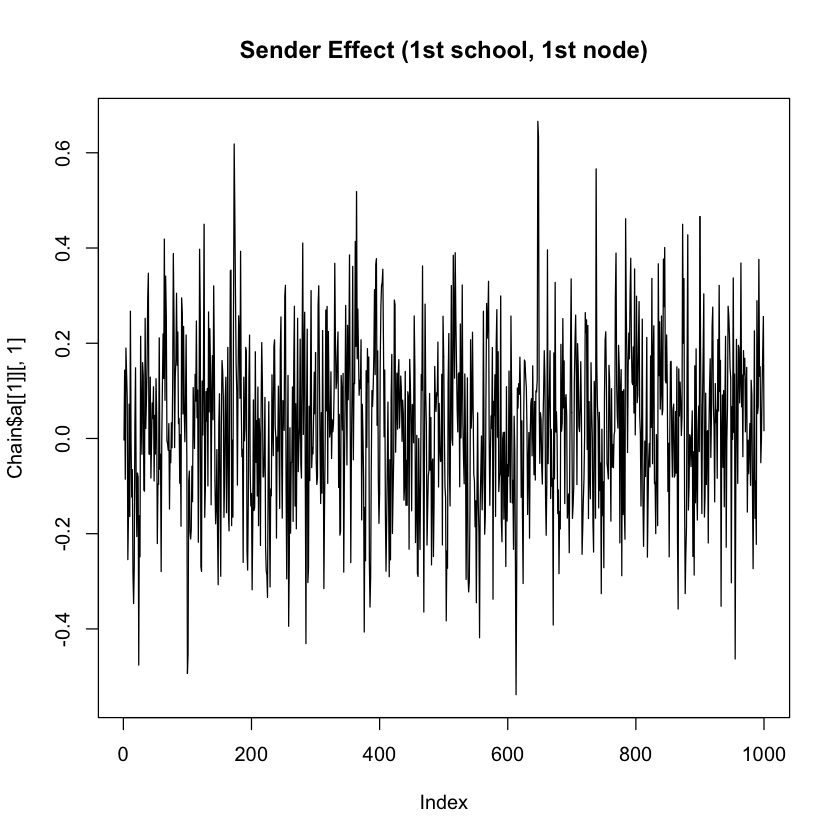

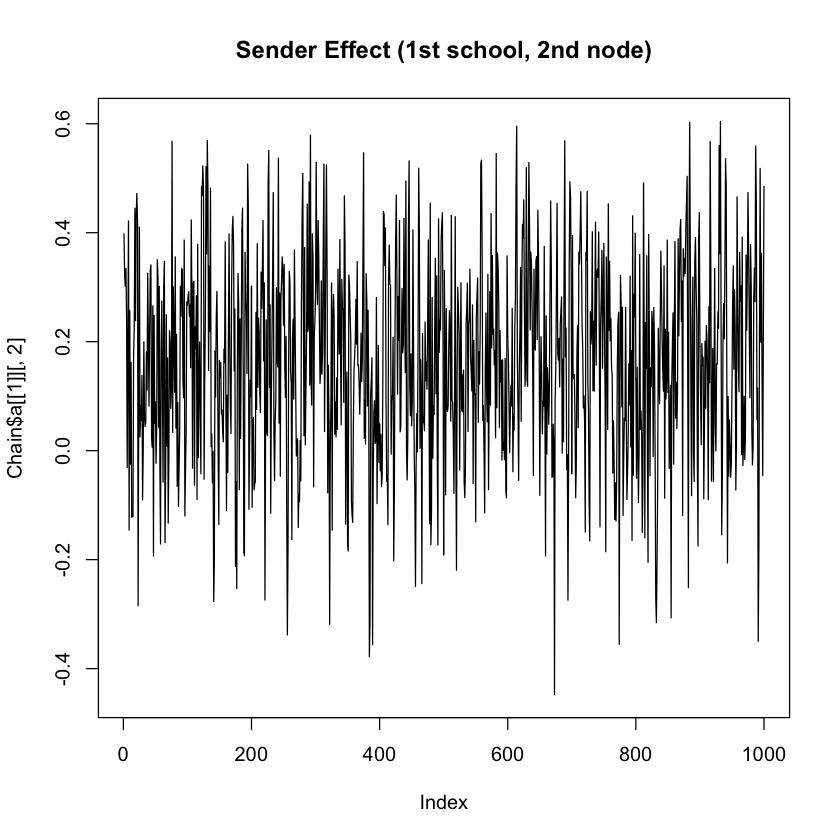

In [39]:
plot(Chain$a[[1]][,1],type="l", main="Sender Effect (1st school, 1st node)")
plot(Chain$a[[1]][,2],type="l", main="Sender Effect (1st school, 2nd node)")

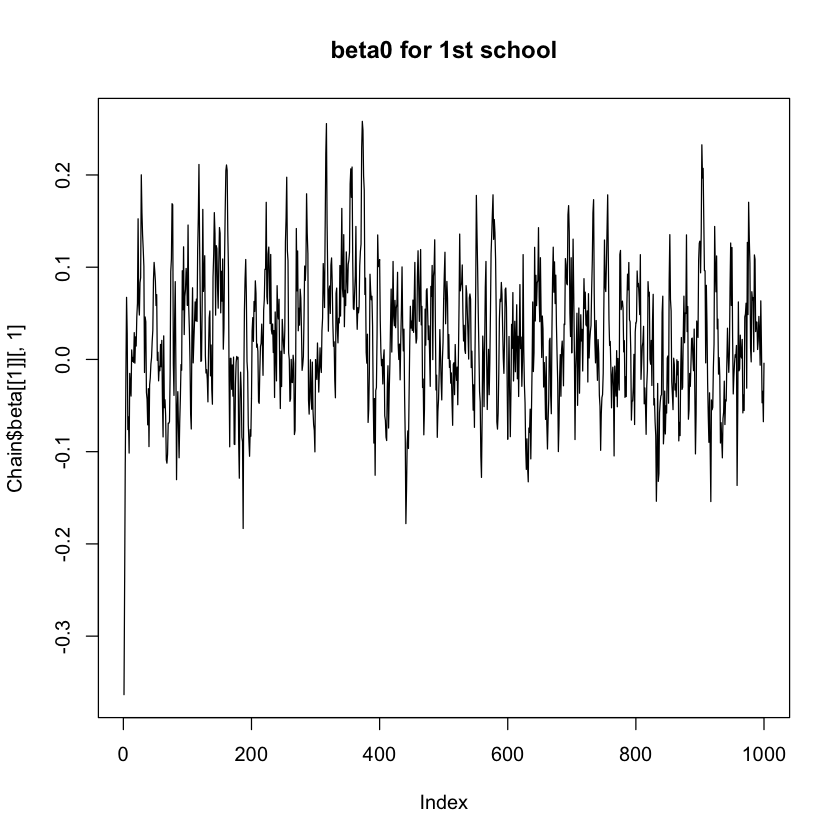

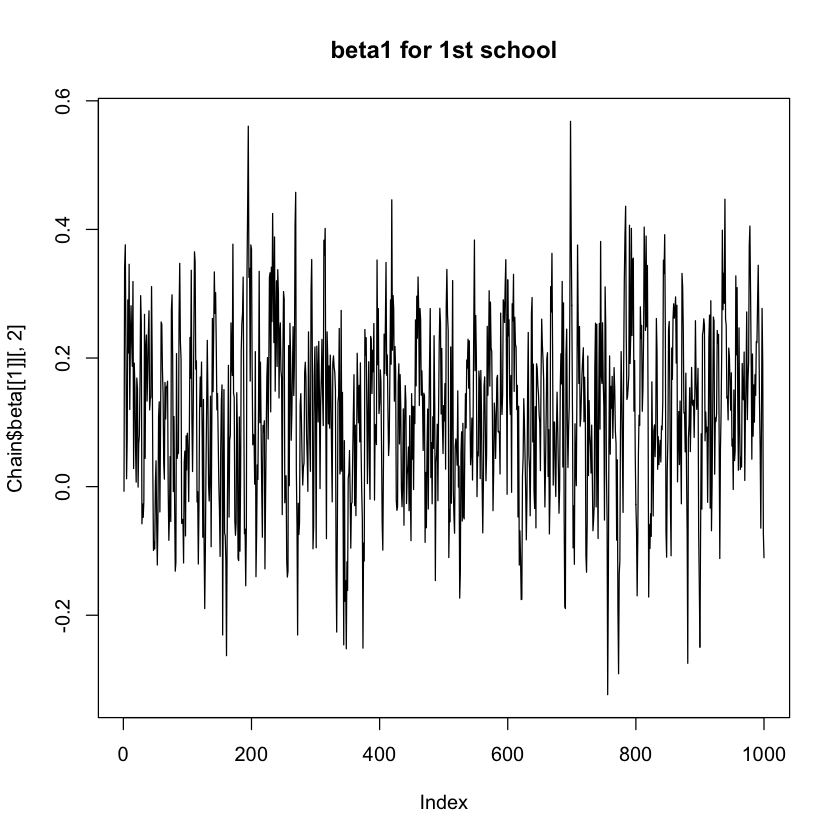

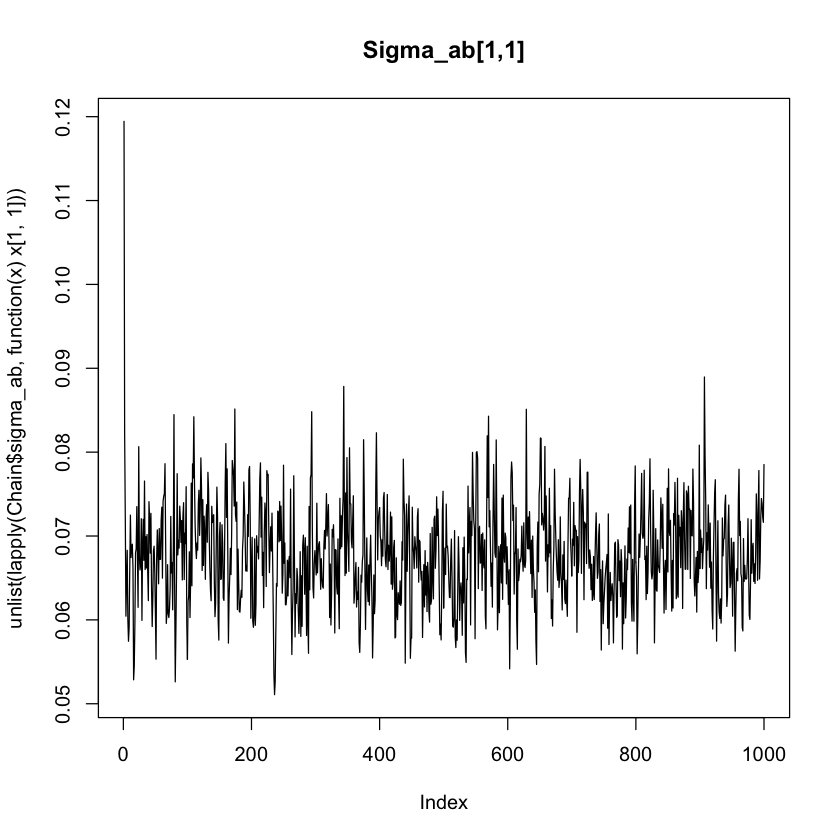

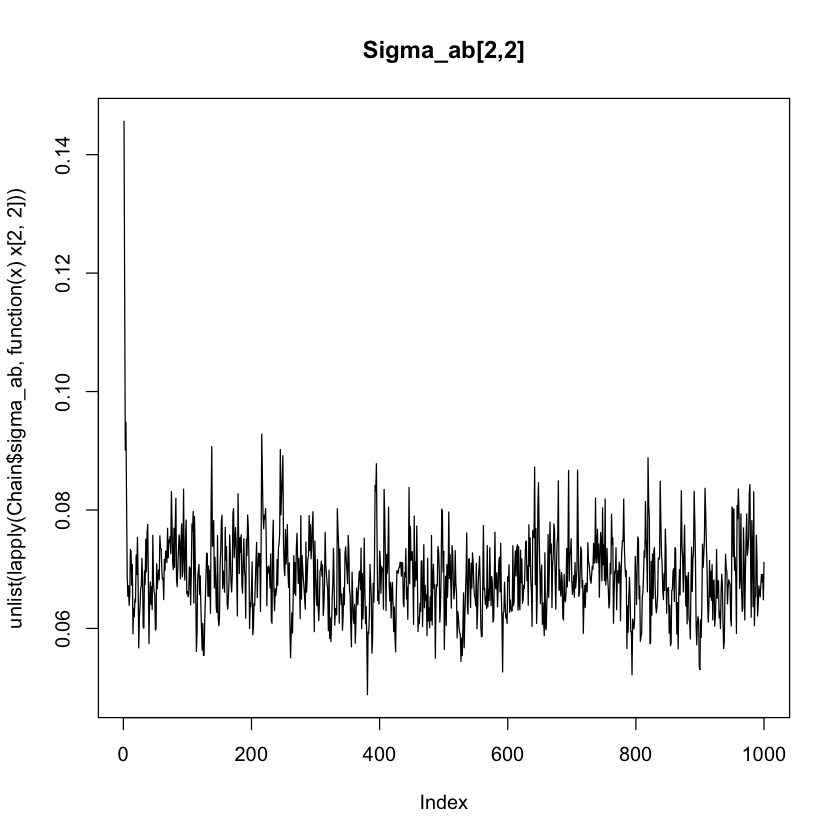

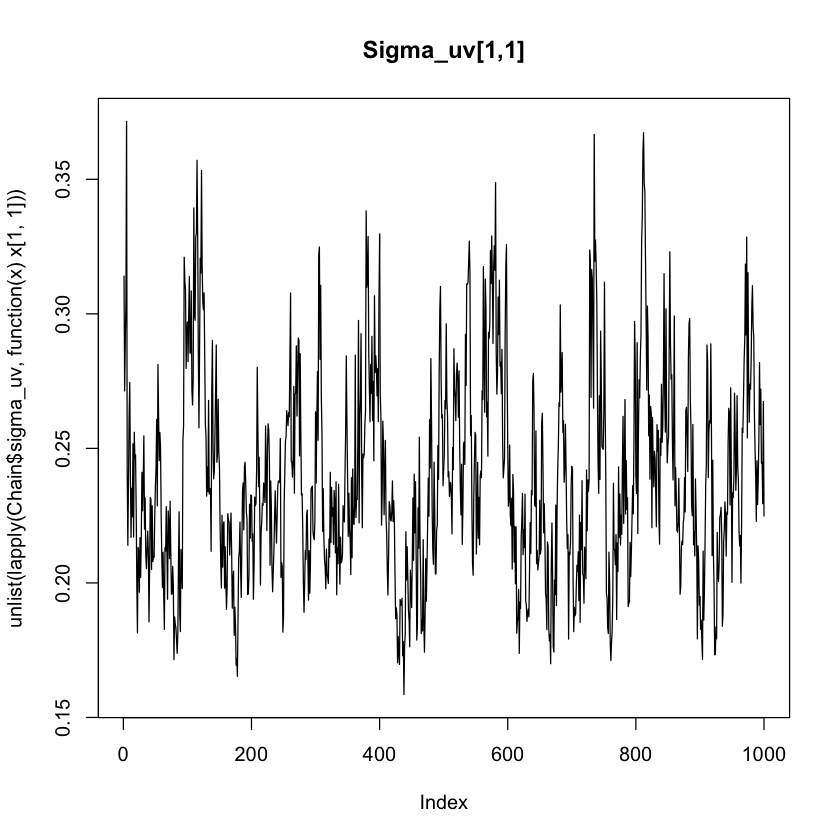

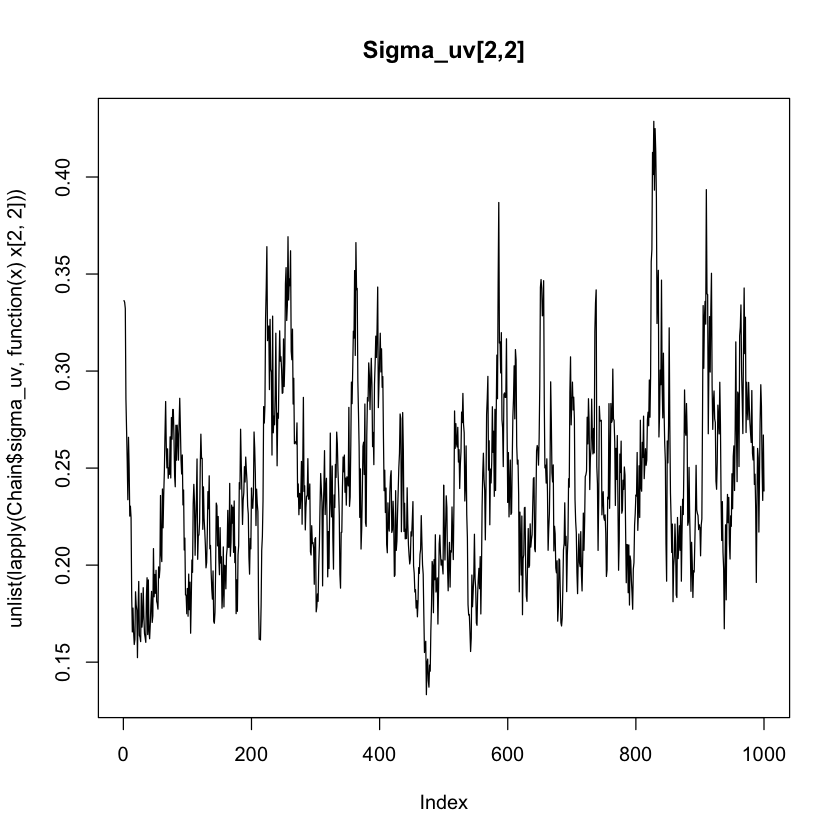

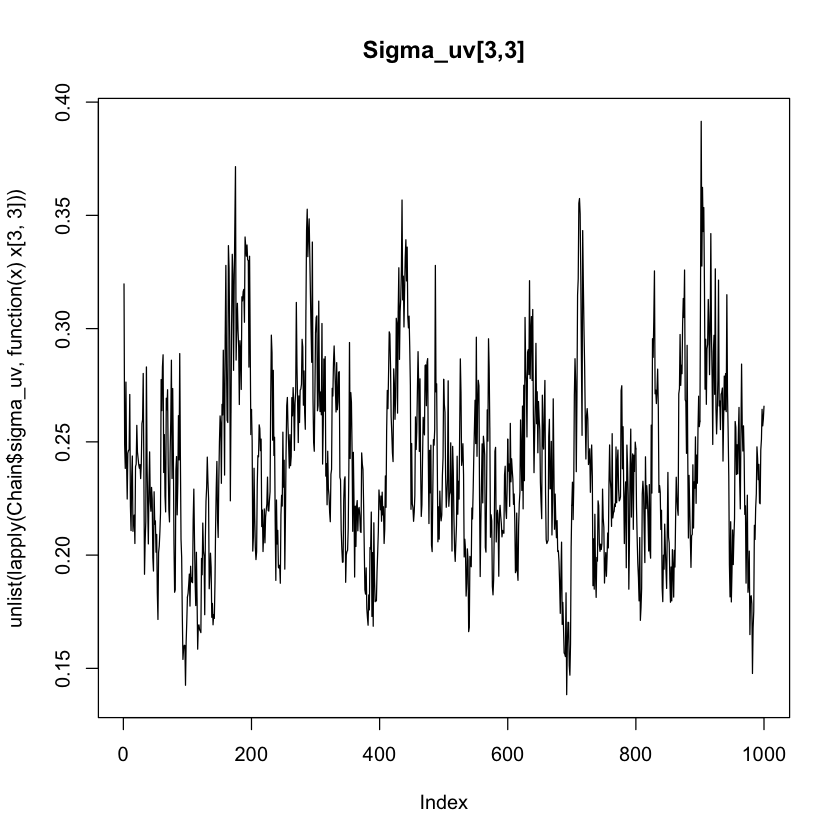

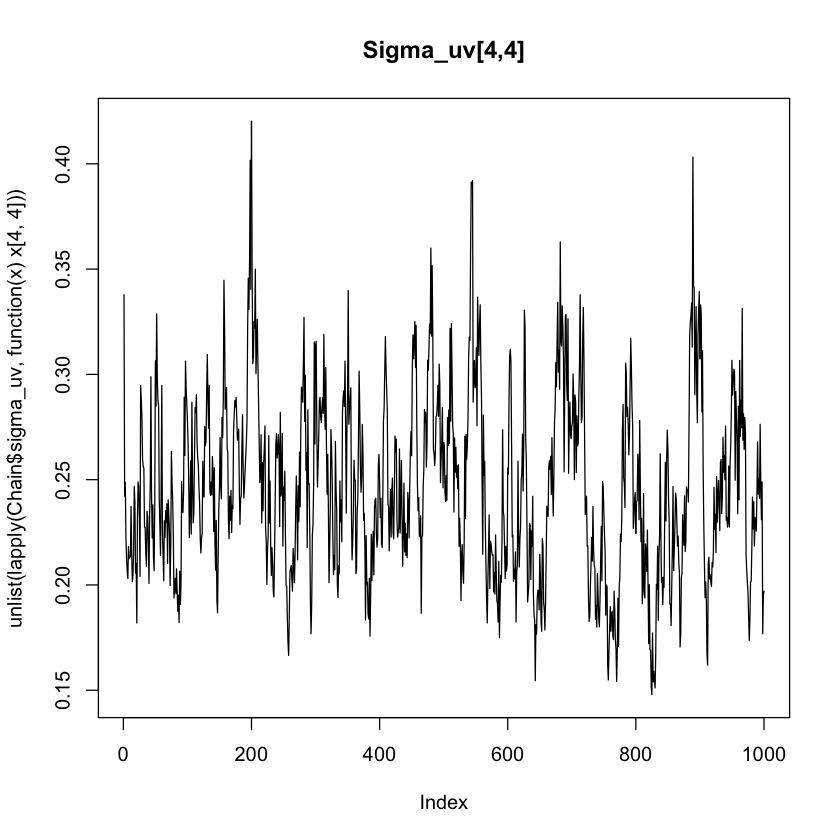

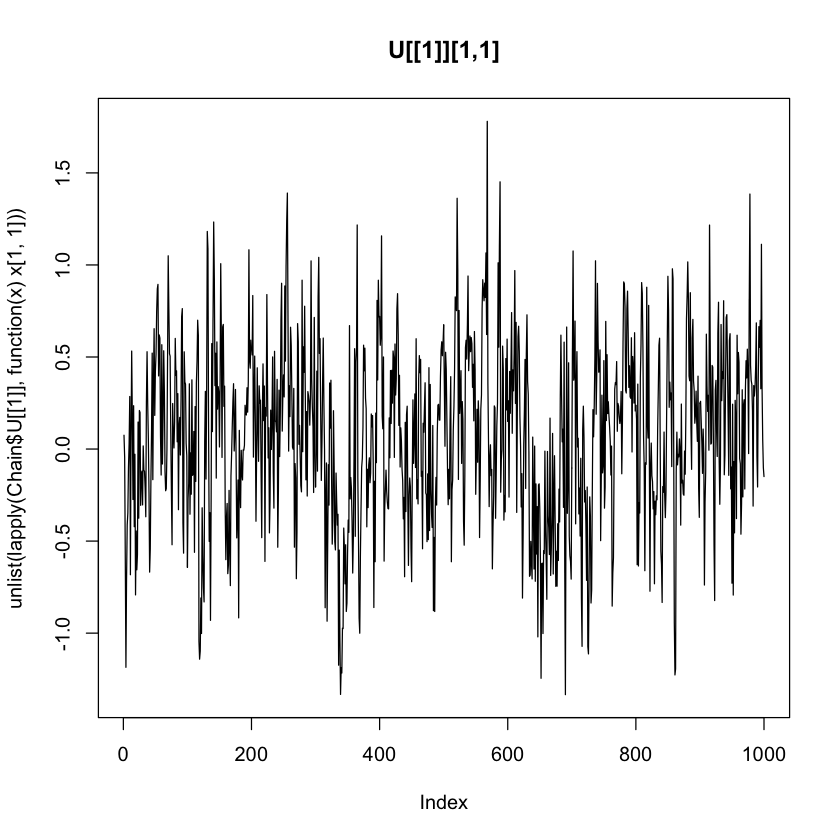

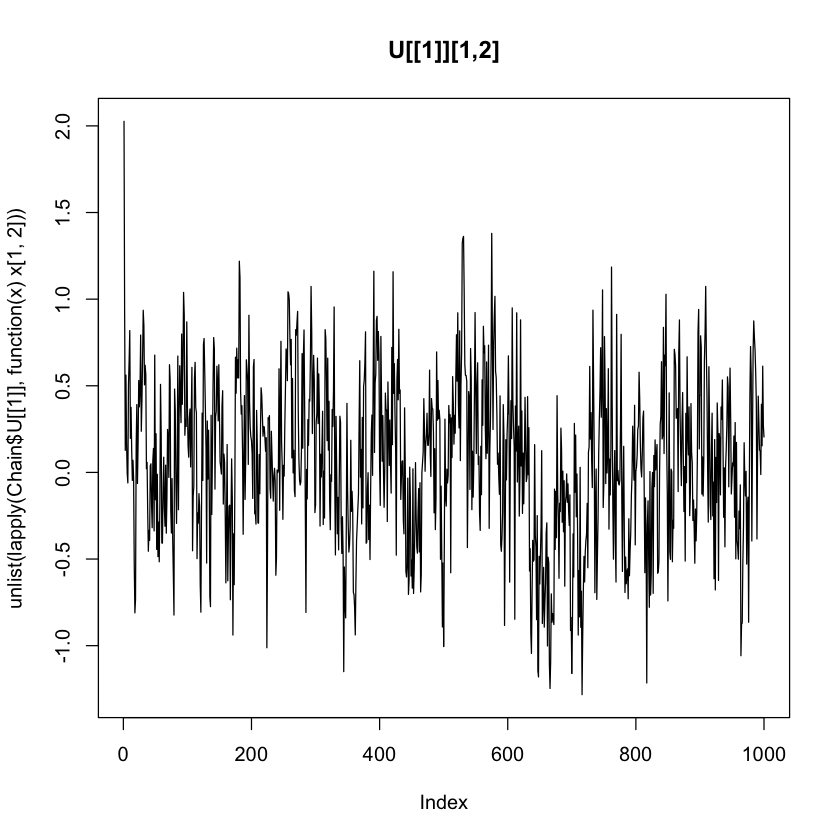

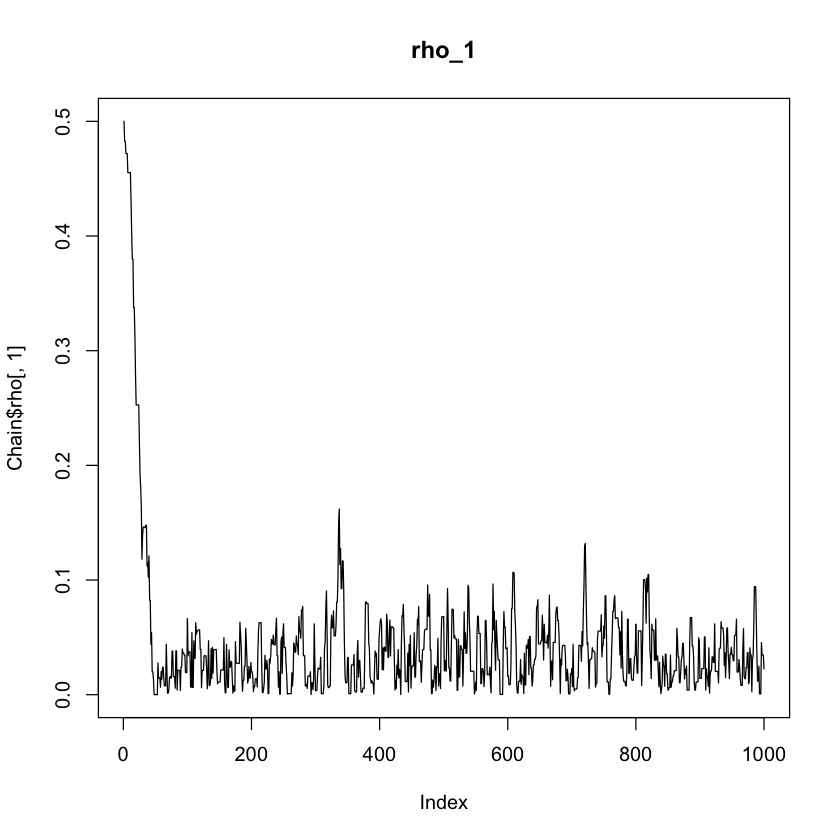

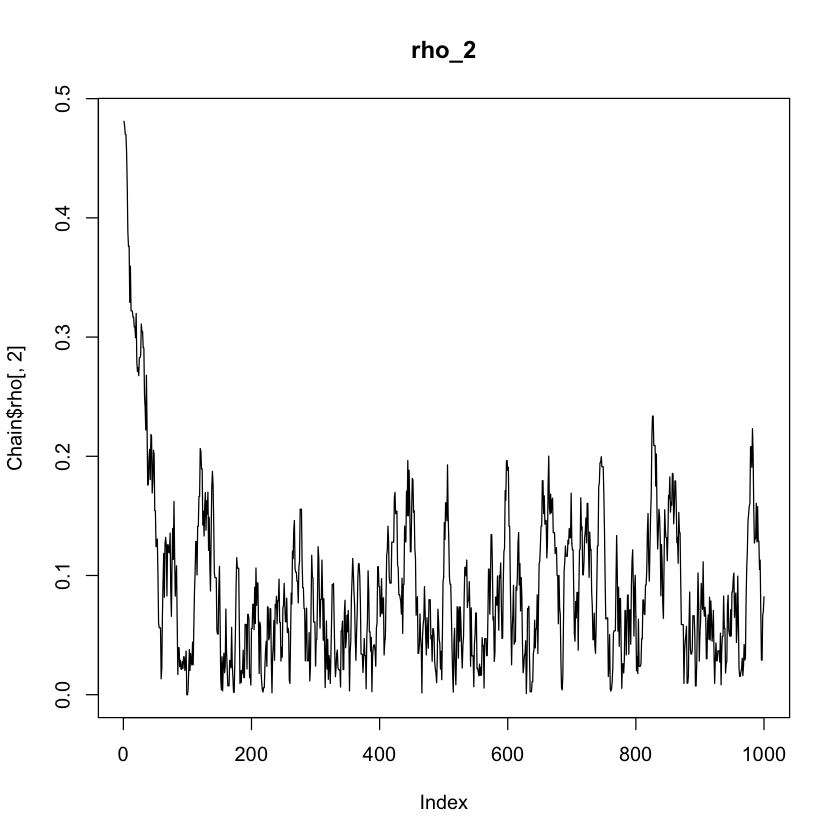

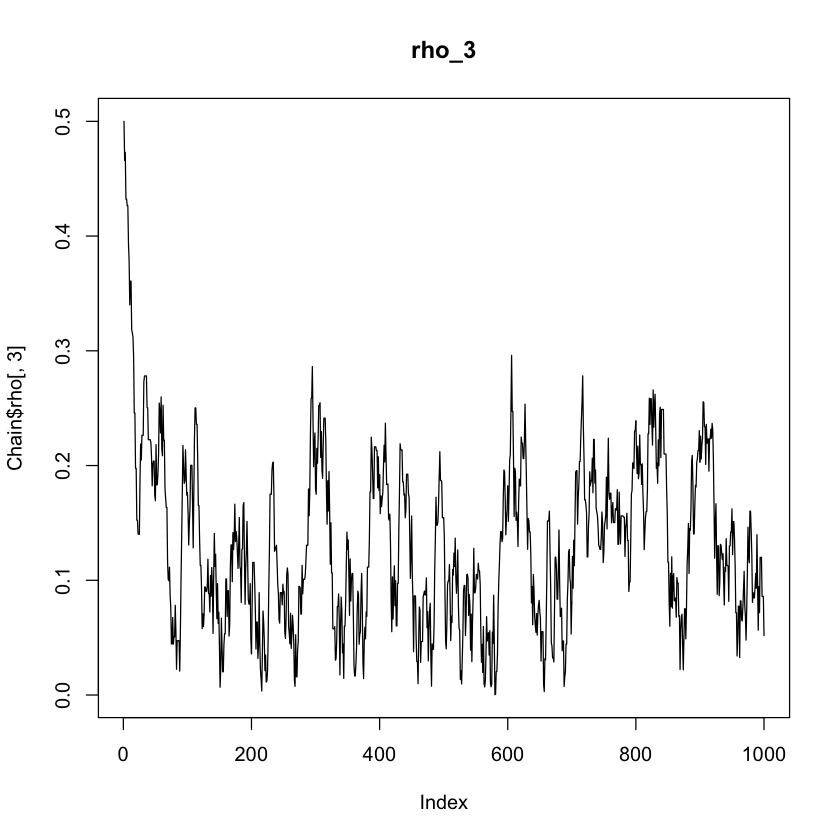

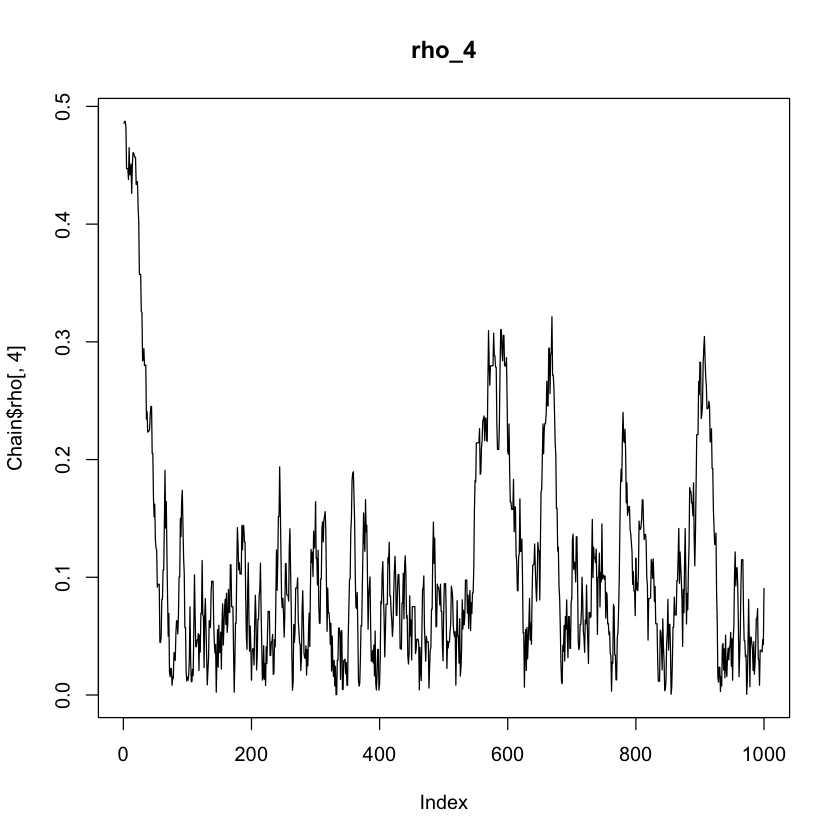

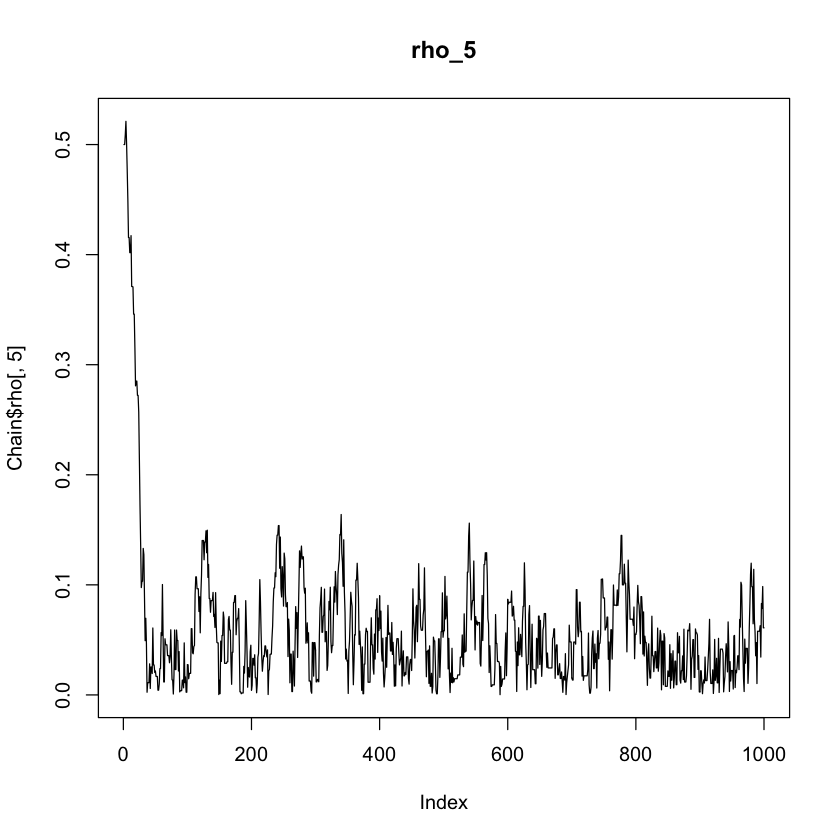

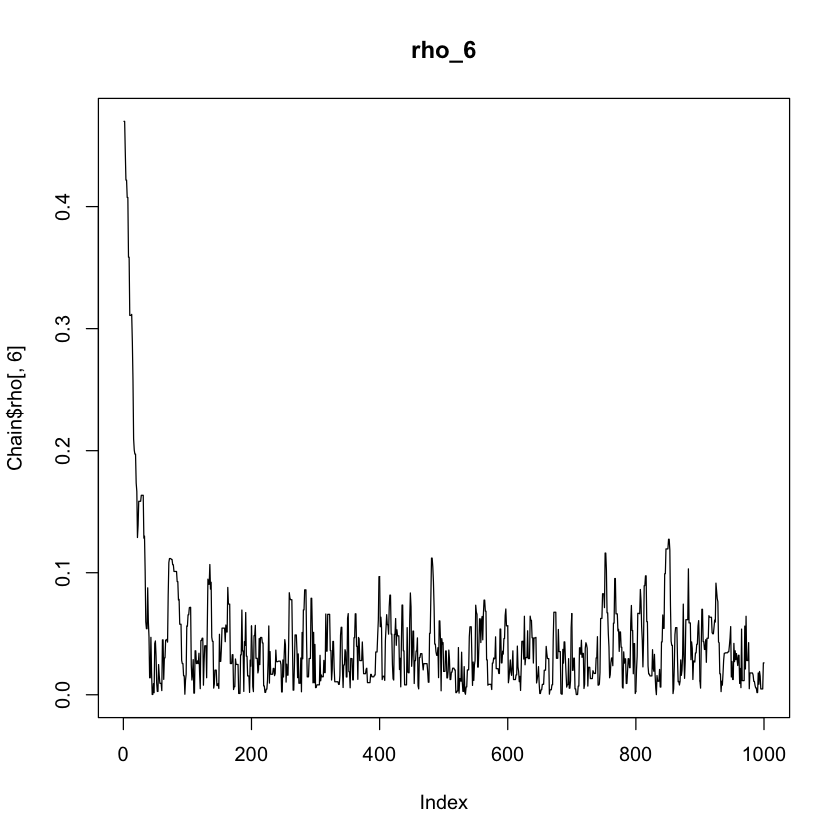

In [40]:
plot(Chain$beta[[1]][,1],type="l", main="beta0 for 1st school")
plot(Chain$beta[[1]][,2],type="l", main="beta1 for 1st school")

plot(unlist(lapply(Chain$sigma_ab, function(x) x[1,1])), type="l", main="Sigma_ab[1,1]")
plot(unlist(lapply(Chain$sigma_ab, function(x) x[2,2])), type="l", main="Sigma_ab[2,2]")

plot(unlist(lapply(Chain$sigma_uv, function(x) x[1,1])), type="l", main="Sigma_uv[1,1]")
plot(unlist(lapply(Chain$sigma_uv, function(x) x[2,2])), type="l", main="Sigma_uv[2,2]")
plot(unlist(lapply(Chain$sigma_uv, function(x) x[3,3])), type="l", main="Sigma_uv[3,3]")
plot(unlist(lapply(Chain$sigma_uv, function(x) x[4,4])), type="l", main="Sigma_uv[4,4]")

plot(unlist(lapply(Chain$U[[1]], function(x) x[1,1])), type="l", main="U[[1]][1,1]")
plot(unlist(lapply(Chain$U[[1]], function(x) x[1,2])), type="l", main="U[[1]][1,2]")

plot(Chain$rho[,1], type="l", main="rho_1")
plot(Chain$rho[,2], type="l", main="rho_2")
plot(Chain$rho[,3], type="l", main="rho_3")
plot(Chain$rho[,4], type="l", main="rho_4")
plot(Chain$rho[,5], type="l", main="rho_5")
plot(Chain$rho[,6], type="l", main="rho_6")